In [1]:
%pip install -q "torch>=2.1" "torchvision" "timm>=0.9.2" "transformers>=4.52.0" "Pillow" "gradio>=4.40" "tqdm" "sentencepiece" "peft" "huggingface-hub>=0.24.0" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "nncf>=2.14.0"
%pip install -q "git+https://github.com/huggingface/optimum-intel.git" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q -U --pre "openvino>=2025.0" "openvino-tokenizers>=2025.0" "openvino-genai>=2025.0" --extra-index-url https://storage.openvinotoolkit.org/simple/wheels/nightly

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import requests
from pathlib import Path

if not Path("cmd_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/cmd_helper.py")
    open("cmd_helper.py", "w").write(r.text)


if not Path("gradio_helper.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks//minicpm-v-multimodal-chatbot//gradio_helper.py"
    )
    open("gradio_helper.py", "w").write(r.text)

if not Path("notebook_utils.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py")
    open("notebook_utils.py", "w").write(r.text)

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("vlm_summary_evaluate.ipynb")

Convert model to OpenVINO Intermediate Representation
back to top ⬆️

OpenVINO supports PyTorch models via conversion to OpenVINO Intermediate Representation format. For convenience, we will use OpenVINO integration with HuggingFace Optimum. 🤗 Optimum Intel is the interface between the 🤗 Transformers and Diffusers libraries and the different tools and libraries provided by Intel to accelerate end-to-end pipelines on Intel architectures.

Among other use cases, Optimum Intel provides a simple interface to optimize your Transformers and Diffusers models, convert them to the OpenVINO Intermediate Representation (IR) format and run inference using OpenVINO Runtime. optimum-cli provides command line interface for model conversion and optimization.

General command format:

optimum-cli export openvino --model <model_id_or_path> --task <task> <output_dir>
where task is task to export the model for, if not specified, the task will be auto-inferred based on the model. You can find a mapping between tasks and model classes in Optimum TaskManager documentation. Additionally, you can specify weights compression using --weight-format argument with one of following options: fp32, fp16, int8 and int4. Fro int8 and int4 nncf will be used for weight compression. More details about model export provided in Optimum Intel documentation.

Compress Language Model Weights to 4 bits
back to top ⬆️

For reducing memory consumption, weights compression optimization can be applied using NNCF.

Click here for more details about weight compression

In [2]:
import ipywidgets as widgets

model_ids = [
    "Qwen/Qwen2-VL-2B-Instruct", 
    "Qwen/Qwen2-VL-7B-Instruct", 
    "openbmb/MiniCPM-V-2_6", 
    "Qwen/Qwen2.5-VL-3B-Instruct", 
    "Qwen/Qwen2.5-VL-7B-Instruct",
    "OpenGVLab/InternVL3-1B",
    "OpenGVLab/InternVL3-2B",
    "OpenGVLab/InternVL3-8B",    
]

model_id = widgets.Dropdown(
    options=model_ids,
    default=model_ids[0],
    description="Model:",
)

model_id

Dropdown(description='Model:', options=('Qwen/Qwen2-VL-2B-Instruct', 'Qwen/Qwen2-VL-7B-Instruct', 'openbmb/Min…

In [3]:
print(f"Selected {model_id.value}")
pt_model_id = model_id.value
model_dir = Path(pt_model_id.split("/")[-1]+"-ov")
model_dir

Selected OpenGVLab/InternVL3-2B


PosixPath('InternVL3-2B-ov')

In [4]:
from cmd_helper import optimum_cli
import nncf
import openvino as ov
import shutil
import gc


def compress_lm_weights(model_dir):
    #compression_configuration = {"mode": nncf.CompressWeightsMode.INT4_SYM, "group_size": 64, "ratio": 1.0, "all_layers": True}
    compression_configuration = {"mode": nncf.CompressWeightsMode.INT8}
 
    ov_model_path = model_dir / "openvino_language_model.xml"
    ov_int4_model_path = model_dir / "openvino_language_model_int4.xml"
    ov_model = ov.Core().read_model(ov_model_path)
    ov_compressed_model = nncf.compress_weights(ov_model, **compression_configuration)
    ov.save_model(ov_compressed_model, ov_int4_model_path)
    del ov_compressed_model
    del ov_model
    gc.collect()
    ov_model_path.unlink()
    ov_model_path.with_suffix(".bin").unlink()
    shutil.move(ov_int4_model_path, ov_model_path)
    shutil.move(ov_int4_model_path.with_suffix(".bin"), ov_model_path.with_suffix(".bin"))


if not model_dir.exists():
    #optimum_cli(model_id, model_dir, additional_args={"trust-remote-code": "", "weight-format": "fp16", "task": "image-text-to-text"})
    optimum_cli(pt_model_id, model_dir, additional_args={"trust-remote-code": "", "weight-format": "fp16", "task": "image-text-to-text"})
    compress_lm_weights(model_dir)

Select device
back to top ⬆️

In [5]:
from notebook_utils import device_widget

device = device_widget(default="AUTO")

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU', 'NPU', 'AUTO'), value='AUTO')

In [6]:
import openvino_genai as ov_genai

#pipeline_config = { "CACHE_DIR": ".npucache"}
ov_model = ov_genai.VLMPipeline(model_dir, device=device.value)

In [7]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import cv2
from typing import List, Optional, Union, Sequence
from decord import VideoReader, cpu
from openvino import Tensor
import decord

image_path = "cat.png"

config = ov_genai.GenerationConfig()
config.max_new_tokens = 400


def load_image(image_file):
    if isinstance(image_file, str) and (image_file.startswith("http") or image_file.startswith("https")):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    image_data = np.array(image.getdata()).reshape(1, image.size[1], image.size[0], 3).astype(np.byte)
    return image, ov.Tensor(image_data)


def streamer(subword: str) -> bool:
    """

    Args:
        subword: sub-word of the generated text.

    Returns: Return flag corresponds whether generation should be stopped.

    """
    print(subword, end="", flush=True)


def cv2_get_video_duration(video_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video file.")
        return None

    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = cap.get(cv2.CAP_PROP_FPS)

    if fps == 0:  # Handle cases where FPS might be zero or undefined
        print("Error: FPS is zero or undefined.")
        cap.release()
        return None

    duration_seconds = frame_count / fps
    cap.release()
    return duration_seconds

def load_video(
       video_path,
       clip_start_sec=0.0,
       clip_end_sec=None,
       num_frames=8):
    
    cv2_vr = cv2.VideoCapture(video_path)
    duration = int(cv2_vr.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_id_list = np.linspace(0, duration-1, num_frames, dtype=int)
    frames=[]

    video_data = []
    for frame_idx in frame_id_list:
        cv2_vr.set(1, frame_idx)
        _, frame = cv2_vr.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cv2_vr.release()
    return np.stack(frames)


def time_to_indices(video_reader: decord.VideoReader, time: Union[float, Sequence[float]]) -> np.ndarray:
    times = video_reader.get_frame_timestamp(range(len(video_reader))).mean(-1)
    indices = np.searchsorted(times, time)
    # Use `np.bitwise_or` so it works both with scalars and numpy arrays.
    return np.where(np.bitwise_or(indices == 0, times[indices] - time <= time - times[indices - 1]), indices,
                    indices - 1)

#frames = video_reader.get_batch(time_to_indices(indices))

def load_video_2(video_path: str,
                 max_num_frames: int = 64,
                 resolution: list = [],
                 time_indices: list = []
                ) -> list:
    def uniform_sample(l: list, n: int) -> list:
        gap = len(l) / n
        idxs = [int(i * gap + gap / 2) for i in range(n)]
        return [l[i] for i in idxs]

    if len(resolution) != 0:
        vr = VideoReader(video_path, width=resolution[0],
                         height=resolution[1], ctx=cpu(0))
    else:
        vr = VideoReader(video_path, ctx=cpu(0))


    if len(time_indices) == 0:        
        frame_idx = [i for i in range(0, len(vr), max(1, int(len(vr) / max_num_frames)))]
        if len(frame_idx) > max_num_frames:
            frame_idx = uniform_sample(frame_idx, max_num_frames)
        frames = vr.get_batch(frame_idx).asnumpy()

    else:
        frames = vr.get_batch(time_to_indices(vr, time=time_indices)).asnumpy()

    
    #frames = [Tensor(v.astype('uint8')) for v in frames]
    print('Num frames sampled:', len(frames))
    return frames

def build_indices(stime, etime, num_elements):
    return np.linspace(stime, etime, num_elements)
    
if not Path(image_path).exists():
    url = "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/d5fbbd1a-d484-415c-88cb-9986625b7b11"
    image = Image.open(requests.get(url, stream=True).raw)
    image.save(image_path)

### extract frames

In [8]:
import os
home_path = os.environ['HOME']
video_path = os.path.join(home_path,'vlm_assessment')
filename1 = os.path.join(video_path, 'Gate-4-18-19.mp4')
#vframes=load_video(filename1, clip_start_sec=1.0, clip_end_sec=9.0, num_frames=8)
#vframes=load_video_2(filename1, max_num_frames=8, resolution=[960, 540])
video_duration = cv2_get_video_duration(filename1)
print(f"video duration: {video_duration} s")


video duration: 3600.0 s


In [9]:
from ipywidgets import FloatRangeSlider, IntSlider

time_indices=FloatRangeSlider(
    value=[1.0, 8.0],
    min=0,
    max=video_duration,
    step=0.1,
    description='video frames',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

num_of_frames=IntSlider(
    value=8,
    min=0,
    max=64,
    step=1,
    description='# frames',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

display(time_indices)
display(num_of_frames)

FloatRangeSlider(value=(1.0, 8.0), continuous_update=False, description='video frames', max=3600.0, readout_fo…

IntSlider(value=8, continuous_update=False, description='# frames', max=64)

### select range of frames by time (s)

In [10]:
#indices = build_indices(time_indices.value[0], time_indices.value[1], num_of_frames.value)

#remark: time indices are passed in units of seconds

#indices = build_indices(377,384,8)  #GT:0
#indices = build_indices(1960,1977,8) #GT:1
indices = build_indices(660,667,8)
#indices = build_indices(665, 673, 8)
#indices = build_indices(60,68,9) #GT: 1

vframes = load_video_2(filename1, time_indices=indices, resolution=[960, 540])

#vframes_bgr = [cv2.cvtColor(f, cv2.COLOR_RGB2BGR) for f in vframes]


Num frames sampled: 8


### Draw line with cv2

In [11]:
# Define line parameter
start_point = (0, 280)
end_point = (960, 280)
#color = (255, 0, 0)  #BGR
color=(0, 0, 255)
thickness = 3

for f in vframes:
    cv2.line(f, start_point, end_point, color, thickness)
    

### display extracted frames


num of frames: 8


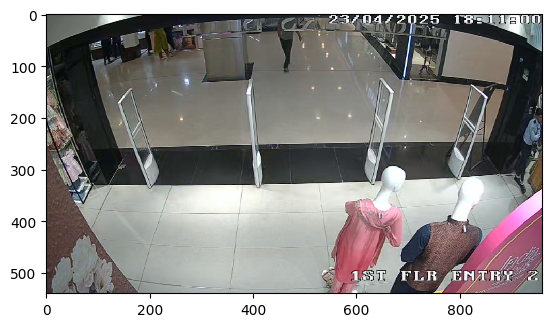

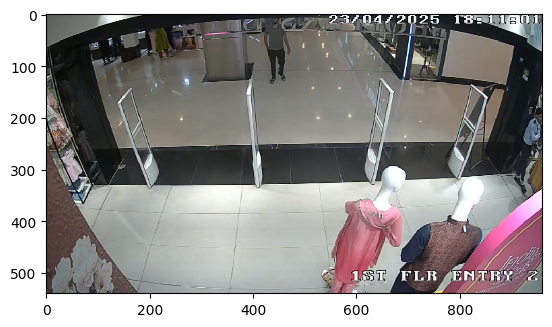

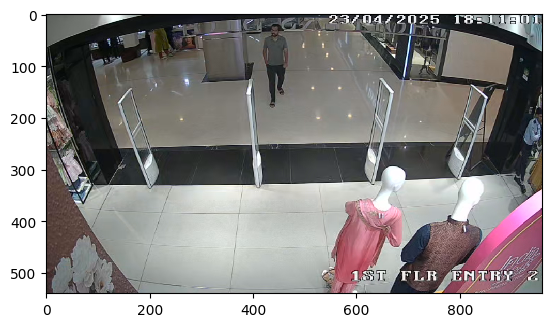

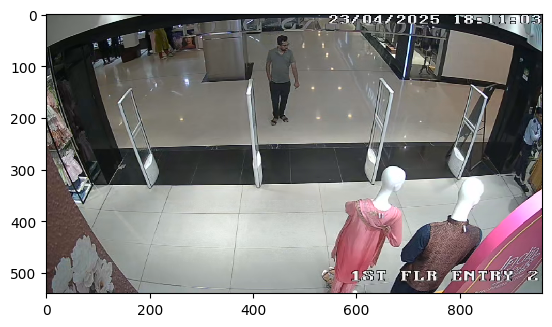

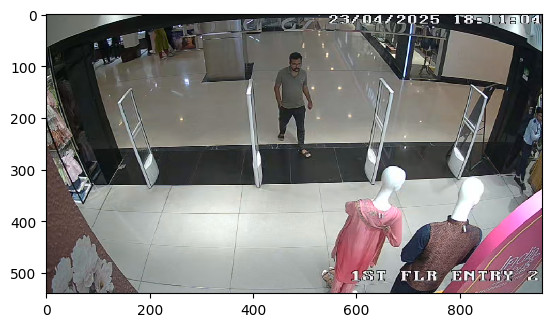

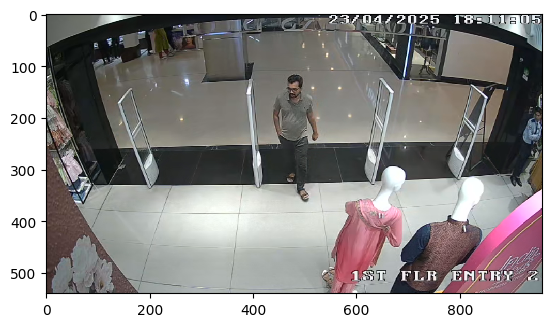

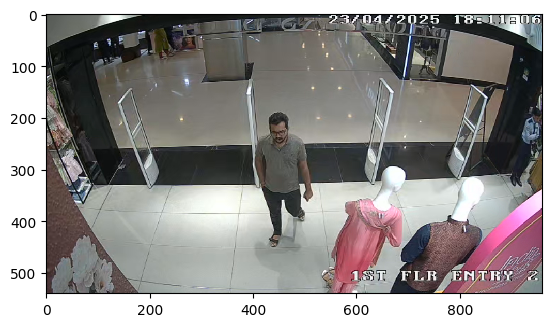

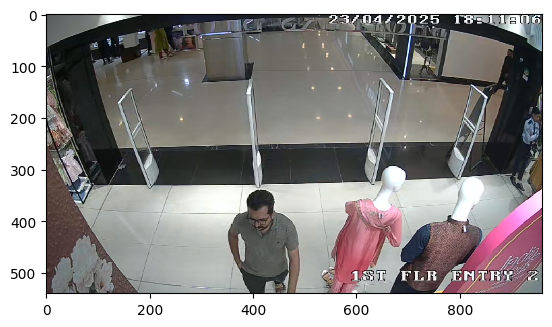

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
print(f"num of frames: {len(vframes)}")
for vframe in vframes:
    plt.imshow(vframe, interpolation='nearest')
    plt.show()


In [16]:
#image, image_tensor = load_image(image_path)
ov_tensors = [ Tensor(v) for v in vframes ]

#question = "Track number of people crosses the blue line ? Do not count the same individual, and provides at least 3 attributes including gender of the person performing the event and time of the event"
#question = "how many image are there in the video sequence ?"
#question = """
#track and count only distinct people having moved across the blue horizontal line in the video sequence. No verbosity. Do not count same person seen in consecutive frames twice. And generate your output in the following template:
# details: (remark the frame number and capture the time on the frame and describe the person).
# unique people counter: (number of distinct people crosses the horizontal line across all frames) 
#"""
#question = "what is the person in the striped shirt and dark pants doing in the video"
#question = "what is the color of the floor tiles"
#question = "is there a line in the center of the video ? what color is it ?"
#question = "is there a red line in the video ?"
#question = "are the person wearing grey t-shirt in the video the same person ?"
#question = "describe the camera angle"
#question = "where is the entrance into the store in the frame"
question = """
track and count only distinct people having moved across the entrance of the store in the video sequence. No verbosity. Do not count same person seen in consecutive frames twice. And generate your output in the following template:
 details: (remark the frame number and capture the time on the frame and describe the person).
 unique people counter: (number of distinct people crosses the horizontal line across all frames) 
"""

print(f"Question:\n{question}")


Question:

track and count only distinct people having moved across the entrance of the store in the video sequence. No verbosity. Do not count same person seen in consecutive frames twice. And generate your output in the following template:
 details: (remark the frame number and capture the time on the frame and describe the person).
 unique people counter: (number of distinct people crosses the horizontal line across all frames) 



In [17]:
ov_tensors

[<Tensor: shape[540,960,3] type: u8>,
 <Tensor: shape[540,960,3] type: u8>,
 <Tensor: shape[540,960,3] type: u8>,
 <Tensor: shape[540,960,3] type: u8>,
 <Tensor: shape[540,960,3] type: u8>,
 <Tensor: shape[540,960,3] type: u8>,
 <Tensor: shape[540,960,3] type: u8>,
 <Tensor: shape[540,960,3] type: u8>]

In [19]:
ov_model.start_chat()
output = ov_model.generate(question, images=ov_tensors, generation_config=config, streamer=streamer)
ov_model.finish_chat()

details: 
- Frame 1: A person wearing a gray shirt and dark pants is walking towards the entrance.
- Frame 2: The same person is still walking towards the entrance.
- Frame 3: The person is now standing near the entrance.

unique people counter: 1

The person is distinct across all frames and moves from the entrance towards the camera.